In [3]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

In [4]:
import os
import cv2
import numpy as np

def load_images_from_folder(folder, label):
  images, labels = [], []
  for file in os.listdir(folder):

      path =  os.path.join(folder, file)
      img = cv2.imread(path)
      if img is None:
        continue
      img = cv2.resize(img, (64, 64))
      images.append(img)
      labels.append(label)
  return images, labels


In [11]:
!unzip superhero-dataset.zip -d superhero-dataset

Archive:  superhero-dataset.zip
   creating: superhero-dataset/superhero-dataset/
   creating: superhero-dataset/superhero-dataset/batman/
  inflating: superhero-dataset/superhero-dataset/batman/Screenshot from 2025-12-29 09-47-24.png  
  inflating: superhero-dataset/superhero-dataset/batman/Screenshot from 2025-12-29 09-08-55.png  
  inflating: superhero-dataset/superhero-dataset/batman/Screenshot from 2025-12-29 09-08-38.png  
  inflating: superhero-dataset/superhero-dataset/batman/Screenshot from 2025-12-29 09-08-28.png  
  inflating: superhero-dataset/superhero-dataset/batman/Screenshot from 2025-12-29 09-08-25.png  
  inflating: superhero-dataset/superhero-dataset/batman/Screenshot from 2025-12-29 09-08-21.png  
  inflating: superhero-dataset/superhero-dataset/batman/Screenshot from 2025-12-29 09-08-15.png  
  inflating: superhero-dataset/superhero-dataset/batman/Screenshot from 2025-12-29 09-07-40.png  
  inflating: superhero-dataset/superhero-dataset/batman/Screenshot from 2025-

In [13]:
import os
print(os.getcwd())
print(os.listdir("."))
print(os.listdir("superhero-dataset"))

/content
['.config', 'superhero-dataset.zip', 'cnn_utils.py', 'superhero-dataset', '__pycache__', 'sample_data']
['superman', 'spiderman', 'batman', 'superhero-dataset']


In [14]:
# defining the dataset path & label
dataset_dir = "superhero-dataset"

classes = sorted(os.listdir(dataset_dir))
label_map = {name: i for i, name in enumerate(classes)}


print(label_map)

{'batman': 0, 'spiderman': 1, 'superhero-dataset': 2, 'superman': 3}


In [15]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_split_superhero_dataset(dataset_dir, img_size=(64, 64), test_size=0.2):
    classes = sorted(os.listdir(dataset_dir))
    label_map = {name: i for i, name in enumerate(classes)}

    X, Y = [], []

    for class_name, label in label_map.items():
        folder = os.path.join(dataset_dir, class_name)
        for file in os.listdir(folder):
            path = os.path.join(folder, file)
            img = cv2.imread(path)
            if img is None:
                continue
            img = cv2.resize(img, img_size)
            X.append(img)
            Y.append(label)

    X = np.array(X) / 255.0
    Y = np.array(Y)

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y,
        test_size=test_size,
        random_state=42,
        stratify=Y
    )

    # Match Andrew Ng's expected shapes
    Y_train = Y_train.reshape(1, -1)
    Y_test = Y_test.reshape(1, -1)

    return X_train, Y_train, X_test, Y_test, np.array(classes)


In [17]:
# Loading the data strings
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig , classes = \
    load_and_split_superhero_dataset("superhero-dataset")

y = 3


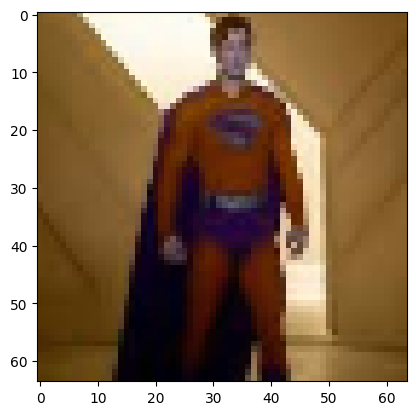

In [18]:
index = 6
plt.imshow(X_train_orig[index])
print("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [19]:
X_train = X_train_orig/255
X_test = X_test_orig/255
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print("number of training examples = " + str(X_train.shape[0]))
print("number of test examples = " + str(X_test.shape[0]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(Y_test.shape))

number of training examples = 123
number of test examples = 31
X_train shape: (123, 64, 64, 3)
Y_train shape: (123, 6)
X_test shape: (31, 64, 64, 3)
Y_test shape: (31, 6)


TensorFlow requires that you create placeholders for the input data that will be fed into the model when running the session.

**Exercise** : Exercise: Implement the function below to create placeholders for the input image X and the output Y. You should not define the number of training examples for the moment. To do so, you could use "None" as the batch size, it will give you the flexibility to choose it later. Hence X should be of dimension [None, n_H0, n_W0, n_C0] and Y should be of dimension [None, n_y]. Hint.


In [20]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


Instructions for updating:
non-resource variables are not supported in the long term


In [21]:
# Graded function : Create placeholders

def create_placeholders(n_H0, n_W0, n_C0, n_y):
  """
  Creates the placeholders for the tensorflow session.

  Arguemnts:
  n_H0: -- scalar , height of an input image
  n_W0: -- scalar, width of an input image
  n_C0: -- scalar , number of channels of the input
  n_y  --- scalar, number of classes

  Returns:
  X -- Placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float
  Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
  """


  X = tf.placeholder(tf.float32,shape=[None, n_H0, n_W0, n_C0])
  Y = tf.placeholder(tf.float32, shape=[None, n_y])

  return X, Y

In [23]:
X , Y = create_placeholders(64, 64, 3, 6)

print("X = "+ str(X))
print("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


## Initailize the parameters

We'll initialize the weights/filters W1 and W2 using
`tf.contrib.layers.xavier_intitalization(seed= 0)`

 You don't need to worry about bias variables as you will soon see that TensorFlow functions take care of the bias. Note also that you will only initialize the weights/filters for the conv2d functions. TensorFlow initializes the layers for the fully connected part automatically.


 Implement initialize_parameters(). The dimensions for each group of filters are provided below. Reminder - to initialize a parameter W of shape [1,2,3,4] in Tensorflow, use:

W = tf.get_variable("W", [1,2,3,4], initializer = ...)





In [24]:
# GRADER Function : Initialize_parametrs

def initialize_parameters():
  """
  initializes weight parameters to build a neural network with tensorflow. The shapes are
             W1 : [4, 4, 3, 8]
             W2 : [2, 2, 8, 16]

  Returns:
  parameters -- a dictionary of tensors containing W1, W2
  """

  tf.set_random_seed(1)

  W1 = tf.get_variable("W1", [4, 4, 3, 8], initializer= tf.keras.initializers.GlorotUniform(seed=0))

  W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer=tf.keras.initializers.GlorotUniform(seed=0))



  parameters = {"W1": W1,
                "W2": W2}


  return parameters

In [25]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))

W1 = [-0.05346771  0.18349849 -0.01215445  0.00138046  0.0012947  -0.02904211
 -0.11260509 -0.143055  ]
W2 = [-0.1713624   0.09527719 -0.0744766  -0.02245569  0.24450928 -0.06879854
  0.21546292 -0.08803296 -0.16513646 -0.19527972 -0.22957063  0.15745944
  0.13090086 -0.12304181 -0.05287278  0.03434092]


`Exercise` : Implement the `forward_propagation` function below to build the following model:

model: `CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN =< FULLYCONNECTED.  We can use the functions above.



In detail, we will use the following parameters for all the steps: - Conv2D: stride 1, padding is "SAME" - ReLU - Max pool: Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME" - Conv2D: stride 1, padding is "SAME" - ReLU - Max pool: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME" - Flatten the previous output. - FULLYCONNECTED (FC) layer: Apply a fully connected layer without an non-linear activation function. Do not call the softmax here. This will result in 6 neurons in the output layer, which then get passed later to a softmax. In TensorFlow, the softmax and cost function are lumped together into a single function, which you'll call in a different function when computing the cost.

In [ ]:
"""
# GRADED FUNCTION : Forward_propagation
def forward_propagation(X, parameters):
  """
  """ Implements the forward propagation for the model

  CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

  Arguments:
  X -- input dataset placeholder , of shape (input size, number of examples)
  parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

  Returns:
  Z3 ---- the output of the last LINEAR unit
  """
"""
  # Retrieve the parameters from the dictionary "parameters"
  W1 = parameters['W1']
  W2 = parameters['W2']

  ### START CODE HERE ###
  # CONV2D: stride of 1, padding 'SAME'
  Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
  # RELU
  A1 = tf.nn.relu(Z1)
  # MAXPOOL: window 8x8, sride 8, padding 'SAME'
  P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
  # CONV2D: filters W2, stride 1, padding 'SAME'
  Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
  # RELU
  A2 = tf.nn.relu(Z2)
  # MAXPOOL: window 4x4, stride 4, padding 'SAME'
  P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
  # FLATTEN
  # P2 = tf.keras.layers.Flatten()(P2)   -- this line made error
  P2 = tf.reshape(P2, [tf.shape(P2)[0], -1])
  P2_dim = P2.get_shape().as_list()[1]

  # FULLY-CONNECTED without non-linear activation function (not not call softmax).
  # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None"
  # Z3 = tf.keras.layers.Dense(6, activation=None)(P2)

  W3 = tf.get_variable(
    "W3",
    shape=[P2_dim, 6],
    initializer=tf.keras.initializers.GlorotUniform(seed=0)
  )
  b3 = tf.get_variable(
      "b3",
      shape=[6],
      initializer=tf.zeros_initializer()
  )

  Z3 = tf.matmul(P2, W3) + b3

  ### END CODE HERE ###

  return Z3








In [27]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']

    Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding='SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize=[1,8,8,1], strides=[1,8,8,1], padding='SAME')

    Z2 = tf.nn.conv2d(P1, W2, strides=[1,1,1,1], padding='SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')

    # Flatten
    P2 = tf.reshape(P2, [-1, 2*2*16])
    P2_dim = 2*2*16

    # Fully connected
    W3 = tf.get_variable(
        "W3",
        shape=[P2_dim, 6],
        initializer=tf.keras.initializers.GlorotUniform(seed=0)
    )
    b3 = tf.get_variable(
        "b3",
        shape=[6],
        initializer=tf.zeros_initializer()
    )

    Z3 = tf.matmul(P2, W3) + b3
    return Z3


In [28]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("Z3 = " + str(a))


Z3 = [[-0.14509061  1.917953   -0.20626272 -0.8656838  -0.6806897  -0.739709  ]
 [ 0.02773425  1.7400942  -0.3648245  -1.1037775  -0.5484282  -0.5629161 ]]


### Compute Cost


Implement the compute cost function below. You might find these two functions helpful:
* **tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y)**: computes the softmax entropy loss. This function both computes the softmax activation function as well as the resulting loss.
* **tf.reduce_mean**: computes the mean of elements across dimensions of a tensor. Use this to sum the losses over all the examples to get the overall cost.



In [33]:
def compute_cost(Z3, Y):
  """
  Compute the cost

  Arguments:
  Z3: output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
  Y -- "true" labels vector placeholder, same shape as Z3

  Return:
  cost - Tensor of the cost function

  """

  cost = tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y)
  cost = tf.reduce_mean(cost)

  return cost



In [36]:
tf.reset_default_graph()

with tf.Session() as sess:
  np.random.seed(1)
  X, Y = create_placeholders(64, 64, 3, 6)
  parameters = initialize_parameters()
  Z3 = forward_propagation(X, parameters)
  cost = compute_cost(Z3, Y)
  init = tf.global_variables_initializer()
  sess.run(init)
  a = sess.run(
      cost,
      feed_dict={
          X: np.random.randn(4, 64, 64, 3),
          Y: np.random.rand(4, 6)
      }
  )
print("cost = " + str(a))

cost = 7.693166


##Model
Finally you will merge the helper functions you implemented above to build a model. You will train it on the SIGNS dataset.



In [39]:
def model(X_train, Y_train , X_test, Y_test, learning_rate=0.009,
          num_epochs=100, minibatch_size=64,print_cost= True):

  """
  Implements a three-layer ConvNet in TensorFlow:
  CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLY_CONNECTED

  Arguments:
  X_train : training set, of shape (None, 64 , 64, 3)
  Y_train : test set, of shape (None, n_y = 6)
  X_test : training set of shape (None, 64, 64, 3)
  Y_test : test_set , of shape (None, n_y = 6)
  learning_rate - learning rate of the optimization
  num_epochs -- number of epochs of the optimization loop
  minibatch_size -- size of a minibatch
  print_cost : True to print the cost every 100 epochs

  Returns
  train_accuracy -- real number , accuracy on the train set (X_train)
  test_accuracy -- real number , testing accuracy on the test set (X_test)
  parameters -- parameters learnt by the model. They can then be used to predict
  """

  ops.reset_default_graph()   # to be able to return the model without overwriting the tf variables
  tf.set_random_seed(1)      # to keep results consistent (tesorflow seed)
  seed = 3                   # to keep results consistent (numpy seed)
  (m, n_H0, n_W0, n_C0) = X_train.shape
  n_y  = Y_train.shape[1]
  costs = []

  # Create placeholder of the correct shape
  X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

  # Initialze parameters
  parameters = initialize_parameters()

  # Forwarrd paropagation : Build the forward propagation in the tf graph

  Z3 = forward_propagation(X, parameters)

  cost = compute_cost(Z3, Y)


  optimizer  = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)


  # Initialize the variables globally
  init = tf.global_variables_initializer()

  with tf.Session() as sess:

    sess.run(init)

    for epoch in range(num_epochs):

      minibatch_cost = 0
      num_minibatches = int(m / minibatch_size)
      seed = seed + 1
      minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

      for minibatch in minibatches:

        # select a minibatch

        (minibatch_X, minibatch_Y) = minibatch

        _, temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y: minibatch_Y})
        minibatch_cost += temp_cost / num_minibatches

        # Print the cost every epoch
      if print_cost == True and epoch % 5 == 0:
        print("Cost after the epoch %i, %f" % (epoch, minibatch_cost))

      if print_cost == True and epoch % 1 == 0:
        costs.append(minibatch_cost)

    plt.plot(np.squeeze(costs))
    plt.ylabel("cost")
    plt.xlabel("iteration (per tens)")
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    # calualte the correct predictions

    predict_op = tf.argmax(Z3, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

    # calculate the accuracy of the test set
    accuracy  = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print(accuracy)
    train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
    test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
    print("Train Accuracy: ", train_accuracy)
    print("Test accuracy: ", test_accuracy)

    return train_accuracy, test_accuracy, parameters












We run the following cell to train the model for 100 epochs. Check if the cost after epoch 0 and 5 matches our output. If not stop the cell and go back to the code

Cost after the epoch 0, 3.572248
Cost after the epoch 5, 3.245325
Cost after the epoch 10, 2.455082
Cost after the epoch 15, 2.191449
Cost after the epoch 20, 2.158231
Cost after the epoch 25, 2.143263
Cost after the epoch 30, 2.124699
Cost after the epoch 35, 2.122253
Cost after the epoch 40, 2.113226
Cost after the epoch 45, 2.101731
Cost after the epoch 50, 2.089649
Cost after the epoch 55, 2.085188
Cost after the epoch 60, 2.052840
Cost after the epoch 65, 2.019591
Cost after the epoch 70, 1.965529
Cost after the epoch 75, 1.909686
Cost after the epoch 80, 1.851326
Cost after the epoch 85, 1.788787
Cost after the epoch 90, 1.737459
Cost after the epoch 95, 1.678382


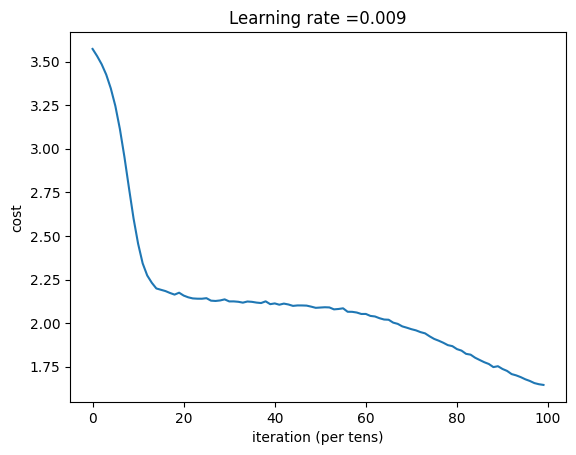

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy:  0.63414633
Test accuracy:  0.516129


In [40]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

In [ ]:
fname = "images/thumbs_up.jpg"
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64, 64))
plt.imshow(my_image)